In [1]:
# plot Lorenz system
import matplotlib.pyplot as plt
import sys, os
sys.path.append('./code_eleves')
import numpy as np
import torch
import torch.nn as nn
from manage_exp import set_tensor_type
from manage_exp import get_x0
from lorenz_exp import get_params

In [9]:
cuda = False #  torch.cuda.is_available()
tensor_type = 'double' # precision numerique
set_tensor_type(tensor_type,cuda)
exp_params = get_params()

use gpu False
use tensor_type double


In [3]:
print('propogator params',exp_params['prop_kwargs'])

propogator params {'loc_classname': 'EDO', 'loc_kwargs': {'x_dim': 40, 'N': 1, 'dt': 0.05, 'init': '95'}, 'gauss_dim': 40, 'scale_vec_classname': 'Cst', 'scale_vec_kwargs': {'init': tensor([-2.3026], dtype=torch.float32)}}


In [4]:
print('observor params',exp_params['obs_kwargs'])

observor params {'loc_classname': 'Id', 'loc_kwargs': {}, 'gauss_dim': 40, 'scale_vec_classname': 'Cst', 'scale_vec_kwargs': {'init': tensor([0.], dtype=torch.float32)}}


In [5]:
# TO modify in filters
    
class EDO(nn.Module):
    """ Integrates an EDO with RK4
    """
    def __init__(self, x_dim, N, dt, init,
                 window=None):
        nn.Module.__init__(self)
        self.x_dim = x_dim
        self.N = N
        self.dt = dt
        if init == "95":
            """ Lorenz95 initialization
            """
            self.window = (-2, -1, 0, 1)
            self.diameter = 4
            self.A = torch.tensor([[[0., 0., 0., 0.],
                                  [-1., 0., 0., 0.],
                                  [0., 0., 0., 0.],
                                  [0., 1., 0., 0.]]])
            self.b = torch.tensor([[0., 0., -1., 0.]])
            self.c = torch.tensor([8.])
        else:
            raise NameError("EDO init not available")

    def edo(self, x):
        """v=
        x-2 x-1 x0 x1
        |   |   |  |
        """
        v = torch.cat(
            [torch.roll(x.unsqueeze(1), -i, 2) for i in self.window], 1)
        v = torch.transpose(v, 1, 2)
        v_flat = v.reshape(-1, self.diameter)
        dx = torch.nn.functional.bilinear(v_flat, v_flat, self.A)\
            + torch.nn.functional.linear(v_flat, self.b, self.c)
        return dx.view(x.size(0), x.size(1))

    def forward(self, x):
        for _ in range(self.N):
            k1 = self.edo(x)
            k2 = self.edo(x + 0.5*self.dt*k1)
            k3 = self.edo(x + 0.5*self.dt*k2)
            k4 = self.edo(x + self.dt*k3)
            x = x + (self.dt/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
        return x


# NO noise in EDO, init from x0 = 0

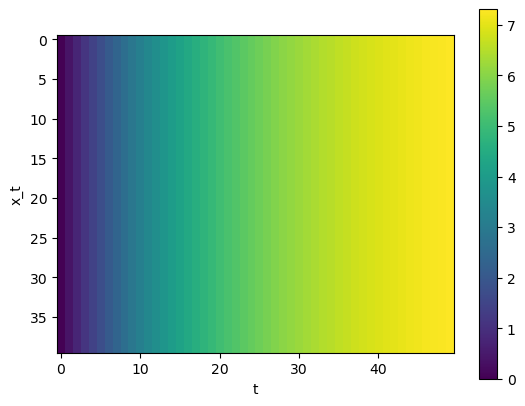

In [6]:
l95 = EDO(40,1,0.05,'95')
T=50
x = torch.zeros((1,40))
img = torch.zeros((40,T))
for t in range(T):
    img[:,t] = x
    x = l95.forward(x)

plt.imshow(img)
plt.xlabel('t')
plt.ylabel('x_t')
#plt.xticks([0,10,20,30,40,50])
#plt.yticks([0,10,20,30,40])
plt.colorbar()

# NO noise in EDO, init from x0 = 8 + perturbation

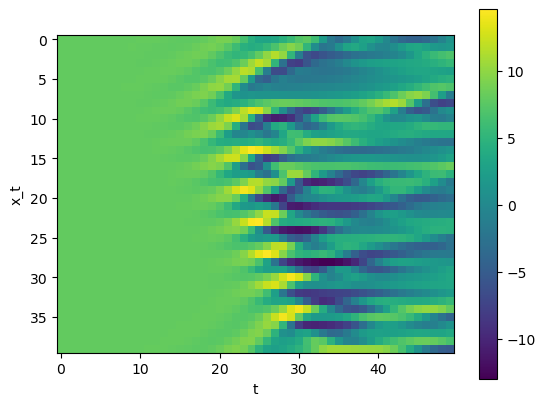

In [7]:
T=50
x = torch.ones((1,40)) * 8.0
x[0,0] += 0.01
img = torch.zeros((40,T))
plt.figure()
for t in range(T):
    img[:,t] = x[0,:]
    #plt.plot(x[0,:])
    x = l95.forward(x)

plt.imshow(img)
plt.xlabel('t')
plt.ylabel('x_t')
#plt.xticks([0,10,20,30,40,50])
#plt.yticks([0,10,20,30,40])
plt.colorbar()

# Baseline

(200, 40)


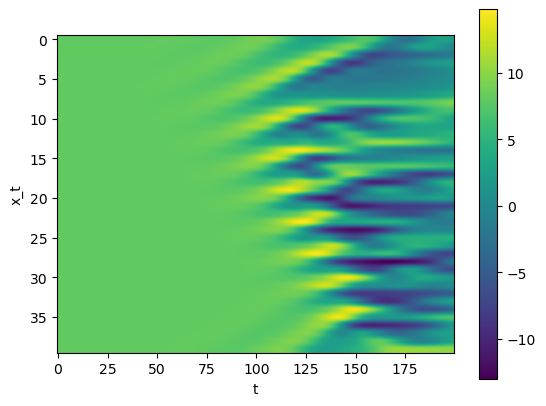

In [8]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

# These are our constants
N = 40  # Number of variables
F = 8  # Forcing

def L96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
#x0 = np.zeros(N)

t = np.arange(0.0, 2, 0.01)

x = odeint(L96, x0, t)
print(x.shape)

plt.imshow(x.transpose(),aspect=4)
plt.xlabel('t')
plt.ylabel('x_t')
#plt.xticks([0,10,20,30,40,50])
#plt.yticks([0,10,20,30,40])
plt.colorbar()